In [1]:
# set your OpenAI API key
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Verify that the API key is loaded
openai_api_key = os.getenv('OPENAI_API_KEY')
anthropic_api_key = os.getenv('ANTHROPIC_API_KEY')

In [2]:
import wat
import ragnostic

import pathlib

data_dir = pathlib.Path("../data/")
document_paths = {
    'journal' : data_dir / 'journal' / 'JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf',
    'textbook' : data_dir / 'textbook' / 'TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf',
    'report' : data_dir / 'report' / 'REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf',
    'article': data_dir / 'article' / 'REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'
}
document_paths = {
    k : str(v.resolve())
    for k,v in document_paths.items()
}
document_paths

{'journal': '/Users/nicholasgrundl/projects/ragnostic/data/journal/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf',
 'textbook': '/Users/nicholasgrundl/projects/ragnostic/data/textbook/TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf',
 'report': '/Users/nicholasgrundl/projects/ragnostic/data/report/REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf',
 'article': '/Users/nicholasgrundl/projects/ragnostic/data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf'}

In [3]:
import uuid

from ragnostic.extraction.core.schema import ContentType, ContentLocation, ExtractedContent, ExtractedText, ExtractedImage, ExtractedTable
from docling_core.types.doc import TextItem, PictureItem, TableItem

def extract_contents_from_doc(doc)->list:
    """Extract contents into pydantic classes"""
    extracted_contents = []
        
    # Iterate through document items in reading order
    for item, level in doc.iterate_items():
        # Handle text content
        if isinstance(item, TextItem):
            location = ContentLocation(
                page=item.prov[0].page_no,
                bbox=(
                    item.prov[0].bbox.l,
                    item.prov[0].bbox.t,
                    item.prov[0].bbox.r,
                    item.prov[0].bbox.b
                )
            )
            
            extracted_text = ExtractedText(
                content_id=str(uuid.uuid4()),
                location=location,
                text=item.text,
                is_header=item.label == "section_header",
                header_level=item.level if hasattr(item, 'level') else None
            )
            extracted_contents.append(extracted_text)
            
        # Handle images
        elif isinstance(item, PictureItem):
            if item.image:
                image_data = item.get_image(doc)  # Get PIL image
                # Convert PIL image to bytes
                import io
                img_byte_arr = io.BytesIO()
                image_data.save(img_byte_arr, format='PNG')
                
                location = ContentLocation(
                    page=item.prov[0].page_no if item.prov else 1,
                    bbox=(0, 0, 0, 0)  # You may need to extract this from item metadata
                )
                
                extracted_image = ExtractedImage(
                    content_id=str(uuid.uuid4()),
                    location=location,
                    image_data=img_byte_arr.getvalue(),
                    format='png',
                    size_bytes=len(img_byte_arr.getvalue()),
                    caption=None #update this later
                )
                extracted_contents.append(extracted_image)
                
        # Handle tables
        elif isinstance(item, TableItem):
            # Convert table to 2D array
            table_data = []
            for row in range(item.data.num_rows):
                table_row = []
                for col in range(item.data.num_cols):
                    cell_text = ""
                    for cell in item.data.table_cells:
                        if (cell.start_row_offset_idx <= row <= cell.end_row_offset_idx and 
                            cell.start_col_offset_idx <= col <= cell.end_col_offset_idx):
                            cell_text = cell.text
                            break
                    table_row.append(cell_text)
                table_data.append(table_row)
            
            location = ContentLocation(
                page=item.prov[0].page_no if item.prov else 1,
                bbox=(0, 0, 0, 0)  # Extract from item metadata if needed
            )
            
            extracted_table = ExtractedTable(
                content_id=str(uuid.uuid4()),
                location=location,
                table_data=table_data,
                caption=None #update this later
            )
            extracted_contents.append(extracted_table)
    return extracted_contents

In [4]:
from IPython.display import display, HTML, Image as IPyImage
from typing import List, Union, Tuple
import pandas as pd
from PIL import Image
import io
import uuid

def preview_extracted_content(
    contents: List[ExtractedContent], 
    max_text_preview: int = 200,
    max_table_rows: int = 5,
    image_max_width: int = 400,
    show_metadata: bool = True
) -> str:
    """
    Display a rich preview of extracted content in Jupyter notebooks.
    
    Args:
        contents: List of ExtractedContent objects
        max_text_preview: Maximum number of characters to show for text previews
        max_table_rows: Maximum number of rows to show for table previews
        image_max_width: Maximum width in pixels for displayed images
        show_metadata: Whether to show location and metadata information
    
    Returns:
        str: The complete HTML content as a string
    """
    
    def create_metadata_html(content: ExtractedContent) -> str:
        """Create HTML for metadata display."""
        metadata_html = f"""
        <div style="font-size: 0.8em; color: #666; margin-top: 5px;">
            📄 Page: {content.location.page} | 
            📍 Bbox: {tuple(round(x, 2) for x in content.location.bbox)} |
            🎯 Confidence: {content.confidence:.2f}
        </div>
        """
        if content.metadata and show_metadata:
            metadata_html += f"""
            <div style="font-size: 0.8em; color: #666;">
                🔍 Additional Metadata: {content.metadata}
            </div>
            """
        return metadata_html

    def create_text_html(content: ExtractedText) -> str:
        text_preview = content.text[:max_text_preview]
        if len(content.text) > max_text_preview:
            text_preview += "..."
            
        header_style = ""
        if content.is_header:
            header_style = f"font-weight: bold; font-size: {1.5-0.2*content.header_level}em;"
            
        return f"""
        <div style="border-left: 3px solid #007bff; padding-left: 10px; margin: 10px 0;">
            <div style="{header_style}">{text_preview}</div>
            {create_metadata_html(content)}
        </div>
        """

    def create_table_html(content: ExtractedTable) -> str:
        df = pd.DataFrame(content.table_data)
        if content.headers:
            df.columns = content.headers
            
        preview_df = df.head(max_table_rows)
        rows_hidden = max(0, len(df) - max_table_rows)
        
        return f"""
        <div style="border-left: 3px solid #28a745; padding-left: 10px; margin: 10px 0;">
            <div style="margin-bottom: 5px;">
                📊 Table ({len(df)} rows × {len(df.columns)} columns)
                {f'| Caption: {content.caption}' if content.caption else ''}
            </div>
            {preview_df.to_html(index=False)}
            {f'<div style="color: #666; font-size: 0.8em;">... and {rows_hidden} more rows</div>' if rows_hidden > 0 else ''}
            {create_metadata_html(content)}
        </div>
        """

    def create_image_html(content: ExtractedImage) -> str:
        try:
            # Convert bytes to PIL Image
            img = Image.open(io.BytesIO(content.image_data))
            
            # Calculate dimensions maintaining aspect ratio
            aspect_ratio = img.width / img.height
            new_width = min(image_max_width, img.width)
            new_height = int(new_width / aspect_ratio)
            
            # Resize image if needed
            if new_width != img.width:
                img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
            
            # Convert image to base64
            buffered = io.BytesIO()
            img.save(buffered, format=content.format)
            img_str = base64.b64encode(buffered.getvalue()).decode()
            
            return f"""
            <div style="border-left: 3px solid #dc3545; padding-left: 10px; margin: 10px 0;">
                <div style="margin-bottom: 5px;">
                    🖼️ Image ({img.width}×{img.height} px, {content.format})
                    {f'| Caption: {content.caption}' if content.caption else ''}
                </div>
                {create_metadata_html(content)}
                <img src="data:image/{content.format.lower()};base64,{img_str}" 
                     style="max-width: 100%; height: auto;" />
            </div>
            """
            
        except Exception as e:
            return f"""
            <div style="color: red;">Error displaying image: {str(e)}</div>
            """

    # Calculate content counts
    content_counts = {
        ContentType.TEXT: 0,
        ContentType.TABLE: 0,
        ContentType.IMAGE: 0
    }
    for content in contents:
        content_counts[content.content_type] += 1

    # Create summary HTML
    summary_html = f"""
    <div style="margin-bottom: 20px; padding: 10px; background-color: #f8f9fa;">
        <h3>Content Summary</h3>
        <ul>
            <li>📝 Text blocks: {content_counts[ContentType.TEXT]}</li>
            <li>📊 Tables: {content_counts[ContentType.TABLE]}</li>
            <li>🖼️ Images: {content_counts[ContentType.IMAGE]}</li>
        </ul>
    </div>
    """

    # Create content preview HTML with collapsible section
    content_html = []
    
    for content in contents:
        if content.content_type == ContentType.TEXT:
            content_html.append(create_text_html(content))
        elif content.content_type == ContentType.TABLE:
            content_html.append(create_table_html(content))
        elif content.content_type == ContentType.IMAGE:
            content_html.append(create_image_html(content))

   # Combine all HTML
    complete_html = f"""
    <div style="max-width: 100%; overflow-x: auto;">
        {summary_html}
        <details>
            <summary style="cursor: pointer; padding: 10px; background-color: #f8f9fa; 
                           margin-bottom: 10px; user-select: none;">
                Click to view content details
            </summary>
            <div style="padding: 10px;">
                {''.join(content_html)}
            </div>
        </details>
    </div>
    """

    # Display the HTML
    display(HTML(complete_html))

    return complete_html

In [31]:
def find_headers_footers(doc):
    headers = []
    footers = []
    
    # Iterate through all text items
    for item in doc.texts:
        if isinstance(item, TextItem):
            if item.label == "page_header":
                headers.append({
                    'text': item.text,
                    'page': item.prov[0].page_no if item.prov else None
                })
            elif item.label == "page_footer":
                footers.append({
                    'text': item.text,
                    'page': item.prov[0].page_no if item.prov else None
                })
    
    return headers, footers

# Let's also inspect all text items to see what labels are present
def inspect_text_items(doc):
    print("\nText items by label:")
    label_counts = {}
    
    for item in doc.texts:
        if item.label not in label_counts:
            label_counts[item.label] = 0
        label_counts[item.label] += 1
        
        # Print first example of each label type
        if label_counts[item.label] == 1:
            print(f"\nLabel: {item.label}")
            print(f"Text sample: {item.text[:100]}...")
            if item.prov:
                print(f"Page: {item.prov[0].page_no}")
    
    print("\nLabel counts:", label_counts)

In [32]:
def create_structured_text(doc):
    # Store content by page
    page_content = {}
    
    for item in doc.texts:
        if not item.prov:
            continue
            
        page_no = item.prov[0].page_no
        if page_no not in page_content:
            page_content[page_no] = {
                'headers': [],
                'body': [],
                'footers': [],
            }
        
        # Skip magazine name, URL and page numbers in footers
        if item.label == 'page_footer' and (
            item.text.strip() in ['CEP'] or 
            'www.' in item.text or 
            item.text.strip().isdigit()
        ):
            continue
            
        if item.label == 'page_footer':
            page_content[page_no]['footers'].append(item.text)
        elif item.label == 'section_header':
            page_content[page_no]['body'].append(f"\n## {item.text}\n")
        elif item.label == 'list_item':
            page_content[page_no]['body'].append(f"• {item.text}\n")
        elif item.label == 'formula':
            page_content[page_no]['body'].append(f"\n[FORMULA]\n")
        elif item.label == 'caption':
            page_content[page_no]['body'].append(f"\n[CAPTION: {item.text}]\n")
        else:
            page_content[page_no]['body'].append(f"{item.text}\n")
    
    # Combine all pages
    full_text = ""
    for page_no in sorted(page_content.keys()):
        content = page_content[page_no]
        full_text += f"\n=== Page {page_no} ===\n\n"
        full_text += "".join(content['headers'])
        full_text += "".join(content['body'])
        full_text += "\n--- Footer ---\n"
        full_text += "".join(content['footers'])
        full_text += "\n\n"
    
    return full_text


# Docling Config

In [5]:
from docling.datamodel.pipeline_options import PdfPipelineOptions, TesseractOcrOptions
from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption

# ==== SETUP PIPELINE ====
pipeline_options = PdfPipelineOptions()

# Table extraction options
pipeline_options.do_table_structure = True  # Enable table structure recognition
pipeline_options.table_structure_options.do_cell_matching = True  # Map structure back to PDF cells
pipeline_options.generate_table_images = True

# Image handling options
pipeline_options.images_scale = 2.0  # Control image resolution/quality
pipeline_options.generate_picture_images = True  # Ensure images are extracted
pipeline_options.generate_page_images = True  # Keep page images for reference

# Performance options
pipeline_options.accelerator_options.num_threads = 4  # Control CPU usage
pipeline_options.accelerator_options.device = "CPU"  # ["CPU","AUTO", etc.]Let Docling choose best device (CPU/GPU/MPS)


# Set OCR in pipeline options
ocr_options = TesseractOcrOptions(
    lang=["eng"],  # Default is ["eng"]. Use ISO 639-2 codes, e.g., ["eng", "fra", "deu"]. 
                   # Use ["auto"] for automatic language detection
    
    force_full_page_ocr=False,  # Default False. Set True to OCR entire pages instead of 
                                # just areas without programmatic text
)

pipeline_options.do_ocr = True  # Enable OCR processing
pipeline_options.ocr_options = ocr_options

In [6]:
# ==== Extract ==== 
pdf_path = document_paths['article']
print(f"PDF Path: {pdf_path}")
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options
        )
    }
)

result = converter.convert(
    pdf_path,
    max_num_pages=100,  # Limit number of pages
    max_file_size=20971520  # Limit file size (20MB in this example)
)

doc = result.document

extracted_contents = extract_contents_from_doc(doc)
html_content = preview_extracted_content(contents=extracted_contents)

PDF Path: /Users/nicholasgrundl/projects/ragnostic/data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf


In [34]:
doc.export_to_markdown(

docling_core.types.doc.document.DoclingDocument

In [33]:
# Use both functions
headers, footers = find_headers_footers(result.document)
print("\nHeaders found:", len(headers))
for h in headers:
    print(f"Page {h['page']}: {h['text']}")

print("\nFooters found:", len(footers))
for f in footers:
    print(f"Page {f['page']}: {f['text']}")

# Inspect all text items to see what we have
inspect_text_items(result.document)


Headers found: 0

Footers found: 11
Page 1: CEP
Page 1: www.cepmagazine.org       May 2003
Page 1: 32
Page 2: CEP
Page 2: May 2003    www.cepmagazine.org
Page 2: 33
Page 3: 34
Page 3: www.cepmagazine.org     May 2003 CEP
Page 4: CEP
Page 4: May 2003   www.cepmagazine.org
Page 4: 35

Text items by label:

Label: section_header
Text sample: Reactions and Separations...
Page: 1

Label: text
Text sample: Benz Technology International, Inc....
Page: 1

Label: list_item
Text sample: ¥ the agitator, which disperses air into the broth and provides for a reasonable level of compositio...
Page: 1

Label: page_footer
Text sample: CEP...
Page: 1

Label: formula
Text sample: ...
Page: 2

Label: caption
Text sample: ■ Figure. To optimize power consumption, the fermenter must be designed in the range where power con...
Page: 3

Label counts: {<DocItemLabel.SECTION_HEADER: 'section_header'>: 14, <DocItemLabel.TEXT: 'text'>: 85, <DocItemLabel.LIST_ITEM: 'list_item'>: 4, <DocItemLabel.PAGE_FOOTER: 'pag

In [30]:
print(create_structured_text(doc))

## Article

PDF Path: /home/nicholasgrundl/projects/ragnostic/data/article/REPORT_2003_OptimizePowerConsumptionInAerobicFermenters.pdf



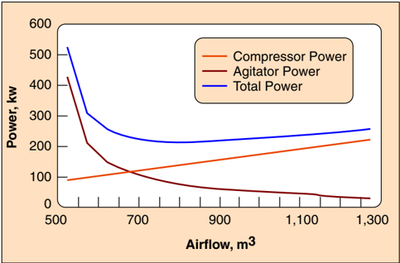

In [56]:
# ==== Extract ==== 
pdf_path = document_paths['article']
print(f"PDF Path: {pdf_path}")
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options
        )
    }
)

result = converter.convert(
    pdf_path,
    max_num_pages=100,  # Limit number of pages
    max_file_size=20971520  # Limit file size (20MB in this example)
)

doc = result.document

extracted_contents = extract_contents_from_doc(doc)
html_content = preview_extracted_content(contents=extracted_contents)

## Report

PDF Path: /home/nicholasgrundl/projects/ragnostic/data/report/REPORT_ConsultancyOnLargeScaleSubmergedAerobicCultivationProcessDesignNRELGenomatica.pdf



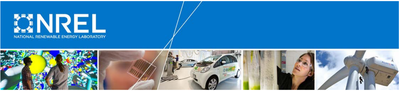
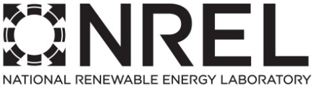
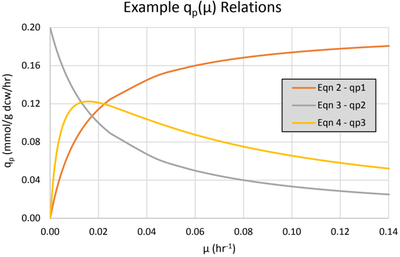
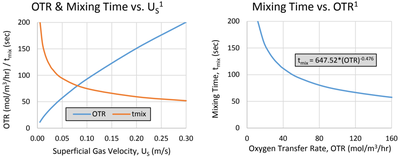
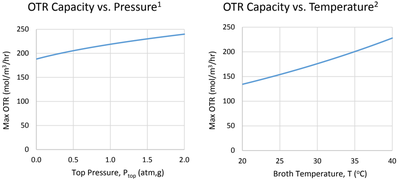
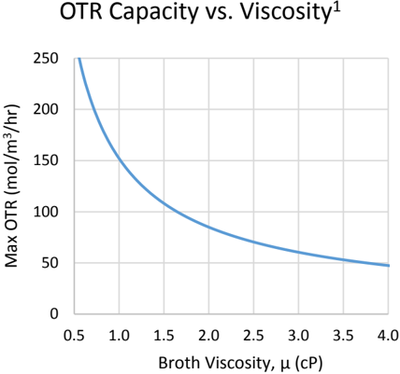
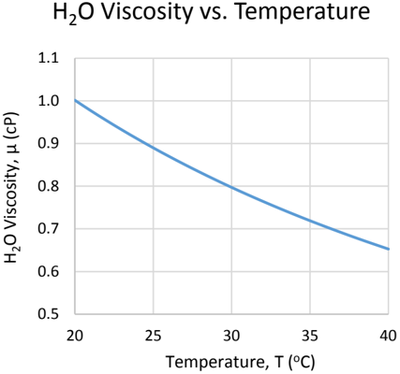
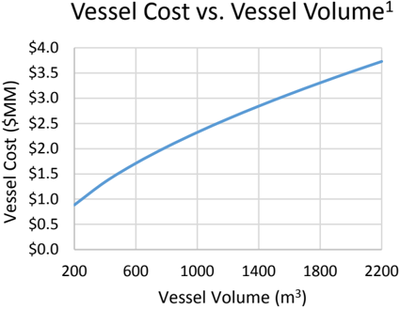
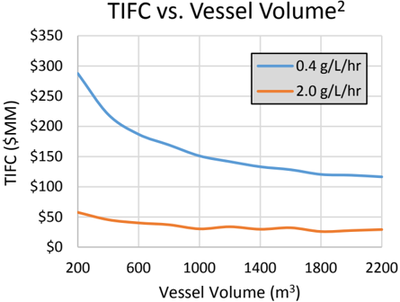
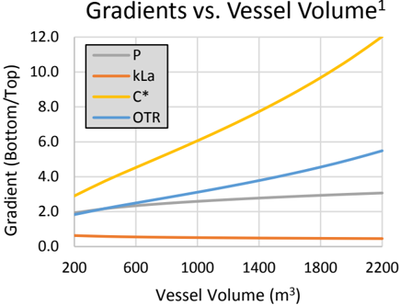
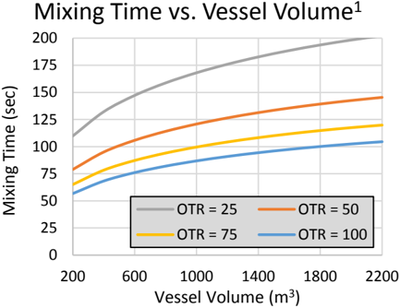
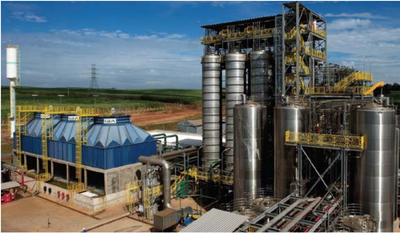
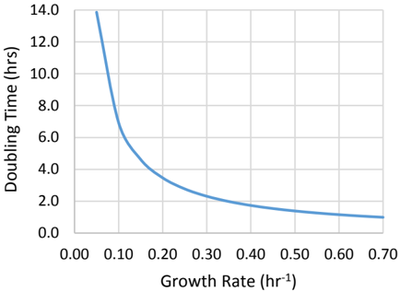
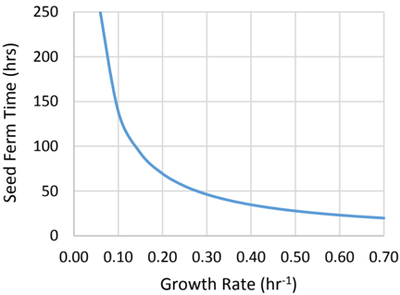

In [57]:
# ==== Extract ==== 
pdf_path = document_paths['report']
print(f"PDF Path: {pdf_path}")
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options
        )
    }
)

result = converter.convert(
    pdf_path,
    max_num_pages=100,  # Limit number of pages
    max_file_size=20971520  # Limit file size (20MB in this example)
)

doc = result.document

extracted_contents = extract_contents_from_doc(doc)
html_content = preview_extracted_content(contents=extracted_contents)

## Journal

PDF Path: /home/nicholasgrundl/projects/ragnostic/data/journal/JOURNAL_2017_AerationCostsInStirredTankAndBubbleColumnBioreactors.pdf



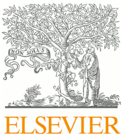
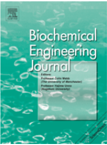
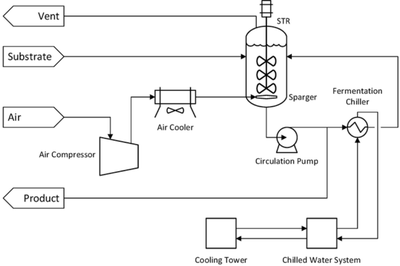
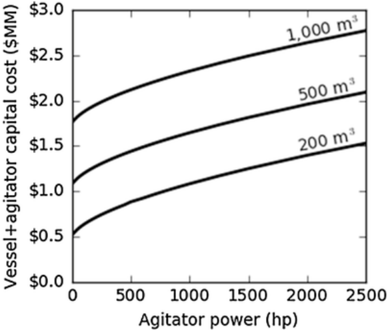
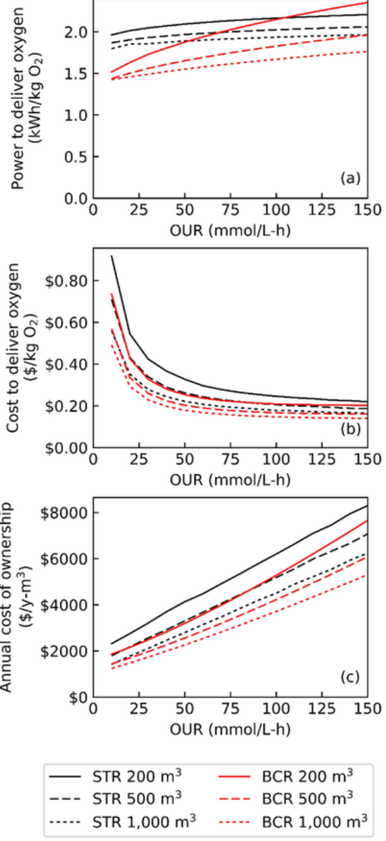

In [58]:
# ==== Extract ==== 
pdf_path = document_paths['journal']
print(f"PDF Path: {pdf_path}")
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options
        )
    }
)

result = converter.convert(
    pdf_path,
    max_num_pages=100,  # Limit number of pages
    max_file_size=20971520  # Limit file size (20MB in this example)
)

doc = result.document

extracted_contents = extract_contents_from_doc(doc)
html_content = preview_extracted_content(contents=extracted_contents)

## Textbook

PDF Path: /home/nicholasgrundl/projects/ragnostic/data/textbook/TEXT_DairyProcessingHandbook_WheyProcessingChapter15.pdf



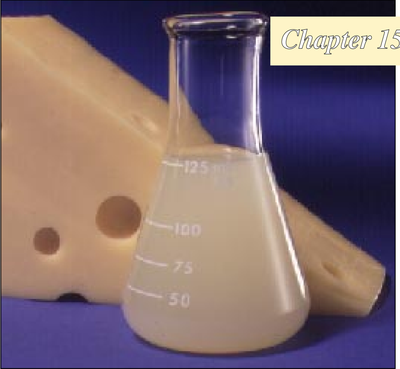
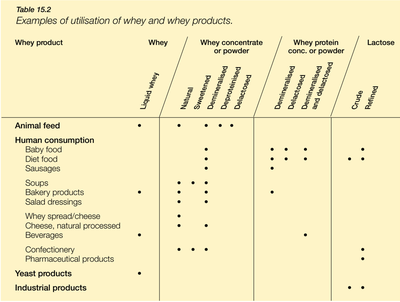
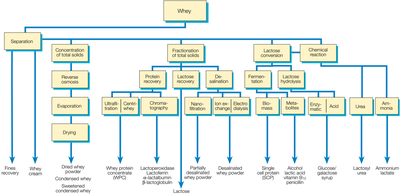
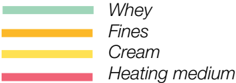
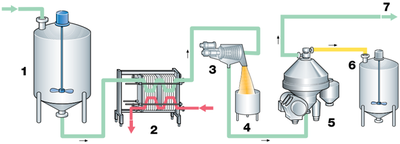
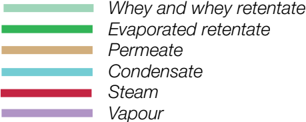
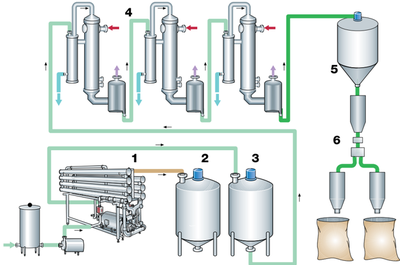
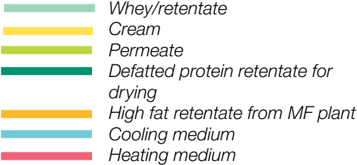
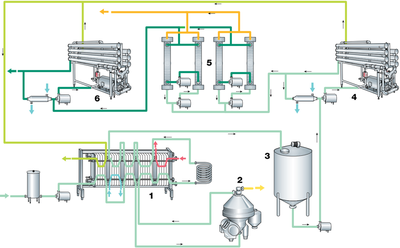
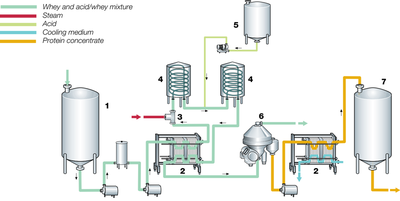
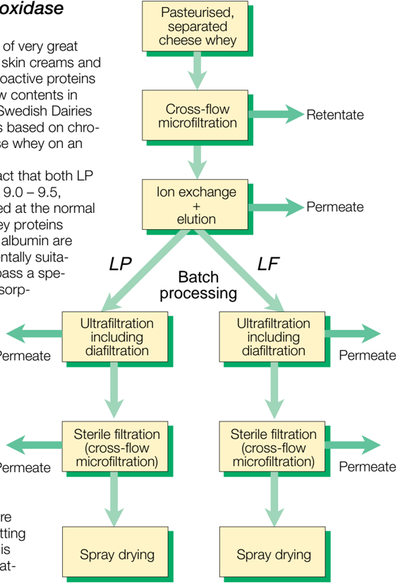
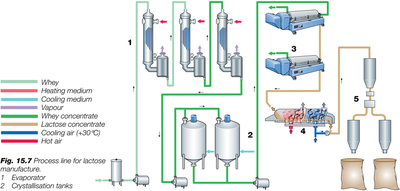
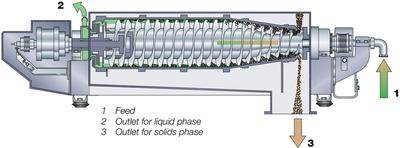
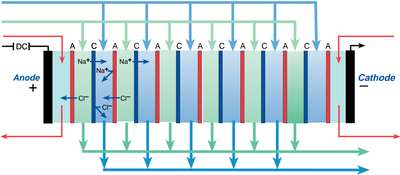
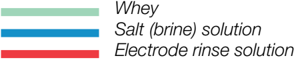
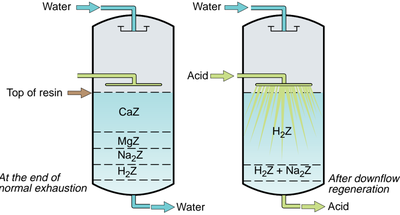
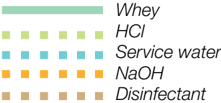
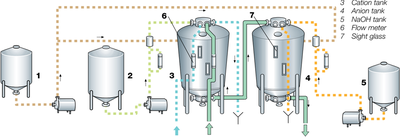
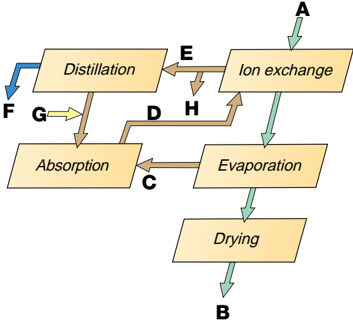
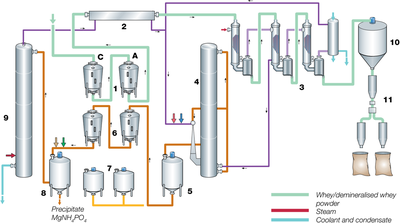
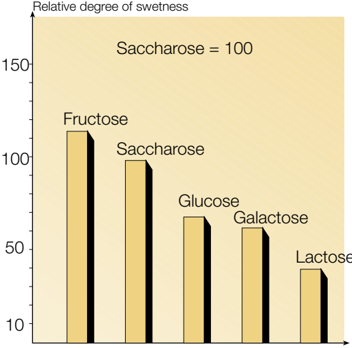
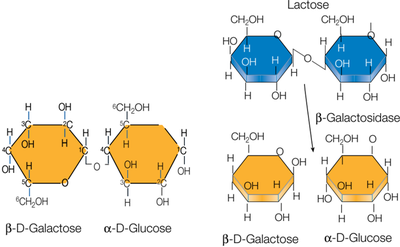
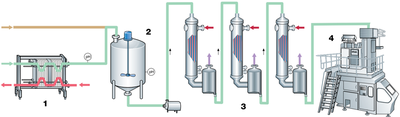
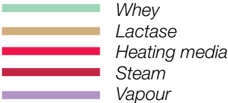

In [59]:
# ==== Extract ==== 
pdf_path = document_paths['textbook']
print(f"PDF Path: {pdf_path}")
converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=pipeline_options
        )
    }
)

result = converter.convert(
    pdf_path,
    max_num_pages=100,  # Limit number of pages
    max_file_size=20971520  # Limit file size (20MB in this example)
)

doc = result.document

extracted_contents = extract_contents_from_doc(doc)
html_content = preview_extracted_content(contents=extracted_contents)